In [1]:
import torch
from torchvision import transforms
from torchvision import transforms,datasets
from torch.utils.data import  DataLoader
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [5]:
cataract_path = "D:\\Note\\data\\cataract"
normal_path = "D:\\Note\\data\\normal"
surgery_path = "D:\\Note\\data\\surgery"
train_data = "D:\\Note\\data\\train"
val_data = "D:\\Note\\data\\val"
test_data = "D:\\Note\\data\\test"

model_path = 'CNN_Classification_cataract.pth'

读取已训练好的模型

In [9]:
model = torch.load(model_path)
model.eval()

Net(
  (conv1): Conv2d(3, 40, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(40, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(60, 80, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pooling2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (pooling3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=23520, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)

### data to load

按6:2:2的比例随机划分，验证集和测试集

In [ ]:
import os
import shutil

path = [cataract_path, normal_path, surgery_path]
type = ["cataract", "normal", "surgery"]

for i in range(3):
    file_name_list = os.listdir(path[i])
    num_image = len(file_name_list)
    train_num = num_image/10*6
    val_num = train_num + num_image/10*2
    id = 0
    for file_name in file_name_list:
        if id <= train_num:
            shutil.move(path[i] + "\\" +file_name, train_data+"\\"+type[i]+"\\"+ file_name)
        elif id <=val_num:
            shutil.move(path[i] + "\\" +file_name, val_data+"\\"+type[i]+"\\"+ file_name)
        else:
            shutil.move(path[i] + "\\" +file_name, test_data+"\\"+type[i]+"\\"+ file_name)
        id += 1

创建自己的数据集

In [7]:
data_transform = transforms.Compose([
    transforms.Resize((512,720)),
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),

])

train_dataset = datasets.ImageFolder(root=train_data, transform=data_transform)
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=10,
                              shuffle=True,
                              num_workers=4)

val_dataset = datasets.ImageFolder(root=val_data, transform=data_transform)
val_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=10,
                              shuffle=True,
                              num_workers=4)

test_dataset = datasets.ImageFolder(root=test_data, transform=data_transform)
test_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=10,
                              shuffle=True,
                              num_workers=4)

### CNN模型

图像输入->卷积层->池化层->卷积层->池化层->卷积层->池化层->全连接层->全连接层

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #三个卷积层
        self.conv1 = torch.nn.Conv2d(3, 40, kernel_size=9)  
        self.conv2 = torch.nn.Conv2d(40, 60, kernel_size=5)
        self.conv3 = torch.nn.Conv2d(60, 80, kernel_size=5)
        #池化层 
        self.pooling = torch.nn.MaxPool2d(kernel_size=2) 
        self.pooling2 = torch.nn.MaxPool2d(kernel_size=5) 
        self.pooling3 = torch.nn.MaxPool2d(kernel_size=3) 
        #全连接层
        self.fc = torch.nn.Linear(23520, 1000)
        self.fc2 = torch.nn.Linear(1000, 3)

    def forward(self, x):
        #先从x数据维度中得到batch_size
        batch_size = x.size(0)
        #卷积层->池化层->激活函数 
        # 40*504*712->40*100*142->60*96*138->60*32*46-》80*28*42-> 80*14*21=23520
        x = F.relu(self.pooling2(self.conv1(x)))
        x = F.relu(self.pooling3(self.conv2(x)))
        x = F.relu(self.pooling(self.conv3(x)))
        x = x.view(batch_size, -1) 
        x = self.fc(x)
        x = self.fc2(x)
        return x

创建Model并为其设置损失函数和优化器

In [74]:
model = Net()
device = torch.device("cpu")
model.to(device) 

Net(
  (conv1): Conv2d(3, 40, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(40, 60, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(60, 80, kernel_size=(5, 5), stride=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pooling2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (pooling3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=23520, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=3, bias=True)
)

In [13]:
#设置损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
#选择Adam作为优化器
optimizer = optim.Adam(model.parameters(), lr=0.002)
# SEG也可以作为优化器
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.5)

### 训练和验证函数

In [76]:
#训练
#将一次迭代封装入函数中
train_loss = []
def train(epoch):
    batchsum_loss = 0
    running_loss = 0.0  
    for batch_idx, data in enumerate(train_dataloader, 0): 
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)

        optimizer.zero_grad()

        #前向 + 反向 + 更新
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batchsum_loss += loss.item()
        if batch_idx % 10 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 10))
            running_loss = 0.0
    train_loss.append(batchsum_loss/180) 

test
利用验证集进行验证

In [77]:
val_loss = []
def test():
    correct = 0
    total = 0
    sum_loss = 0
    with torch.no_grad():  
        for data in test_dataloader:   
            images, labels = data  
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            sum_loss += loss.item()
    print('Accuracy on test set:%d %%' % (100 * correct / total))
    val_loss.append(sum_loss/total)

### 主函数
对模型进行训练、验证以及测试

In [78]:
if __name__ == '__main__':
    for epoch in range(50):
        train(epoch)
        test()

[1,     1] loss: 0.109
[1,    11] loss: 7.593
[1,    21] loss: 1.050
[1,    31] loss: 1.033
[1,    41] loss: 0.945
[1,    51] loss: 0.660
[1,    61] loss: 0.829
[1,    71] loss: 0.682
[1,    81] loss: 0.713
[1,    91] loss: 0.511
[1,   101] loss: 0.718
[1,   111] loss: 0.663
[1,   121] loss: 0.645
[1,   131] loss: 0.510
[1,   141] loss: 0.620
[1,   151] loss: 0.523
[1,   161] loss: 0.669
[1,   171] loss: 0.689
[1,   181] loss: 0.739
Accuracy on test set:25 %
[2,     1] loss: 0.435
[2,    11] loss: 0.700
[2,    21] loss: 0.529
[2,    31] loss: 0.672
[2,    41] loss: 0.551
[2,    51] loss: 0.450
[2,    61] loss: 0.273
[2,    71] loss: 0.329
[2,    81] loss: 0.282
[2,    91] loss: 0.461
[2,   101] loss: 0.687
[2,   111] loss: 0.442
[2,   121] loss: 0.299
[2,   131] loss: 0.485
[2,   141] loss: 0.472
[2,   151] loss: 0.643
[2,   161] loss: 0.763
[2,   171] loss: 0.652
[2,   181] loss: 0.816
Accuracy on test set:72 %
[3,     1] loss: 0.042
[3,    11] loss: 0.803
[3,    21] loss: 0.581
[3,  

[18,    81] loss: 0.170
[18,    91] loss: 0.353
[18,   101] loss: 0.253
[18,   111] loss: 0.356
[18,   121] loss: 0.304
[18,   131] loss: 0.417
[18,   141] loss: 0.259
[18,   151] loss: 0.199
[18,   161] loss: 0.261
[18,   171] loss: 0.424
[18,   181] loss: 0.615
Accuracy on test set:71 %
[19,     1] loss: 0.071
[19,    11] loss: 0.446
[19,    21] loss: 0.263
[19,    31] loss: 0.173
[19,    41] loss: 0.357
[19,    51] loss: 0.170
[19,    61] loss: 0.154
[19,    71] loss: 0.209
[19,    81] loss: 0.230
[19,    91] loss: 0.191
[19,   101] loss: 0.273
[19,   111] loss: 0.236
[19,   121] loss: 0.239
[19,   131] loss: 0.214
[19,   141] loss: 0.332
[19,   151] loss: 0.558
[19,   161] loss: 0.450
[19,   171] loss: 0.312
[19,   181] loss: 0.228
Accuracy on test set:91 %
[20,     1] loss: 0.012
[20,    11] loss: 0.246
[20,    21] loss: 0.169
[20,    31] loss: 0.139
[20,    41] loss: 0.223
[20,    51] loss: 0.297
[20,    61] loss: 0.311
[20,    71] loss: 0.163
[20,    81] loss: 0.334
[20,    91] 

[35,    81] loss: 0.075
[35,    91] loss: 0.213
[35,   101] loss: 0.195
[35,   111] loss: 0.230
[35,   121] loss: 0.200
[35,   131] loss: 0.190
[35,   141] loss: 0.301
[35,   151] loss: 0.286
[35,   161] loss: 0.207
[35,   171] loss: 0.158
[35,   181] loss: 0.170
Accuracy on test set:91 %
[36,     1] loss: 0.024
[36,    11] loss: 0.394
[36,    21] loss: 0.372
[36,    31] loss: 0.424
[36,    41] loss: 0.310
[36,    51] loss: 0.342
[36,    61] loss: 0.138
[36,    71] loss: 0.180
[36,    81] loss: 0.191
[36,    91] loss: 0.137
[36,   101] loss: 0.202
[36,   111] loss: 0.164
[36,   121] loss: 0.132
[36,   131] loss: 0.153
[36,   141] loss: 0.125
[36,   151] loss: 0.099
[36,   161] loss: 0.314
[36,   171] loss: 0.408
[36,   181] loss: 0.217
Accuracy on test set:94 %
[37,     1] loss: 0.005
[37,    11] loss: 0.175
[37,    21] loss: 0.235
[37,    31] loss: 0.204
[37,    41] loss: 0.192
[37,    51] loss: 0.225
[37,    61] loss: 0.182
[37,    71] loss: 0.164
[37,    81] loss: 0.140
[37,    91] 

In [80]:
print(train_loss)
print(val_loss)
torch.save(model, model_path)

[0.7893106937408447, 0.6884799599647522, 0.20240604877471924, 0.25447121262550354, 0.44735369086265564, 0.19546827673912048, 0.10179346799850464, 0.16440346837043762, 0.4168524146080017, 0.3458479344844818, 0.5247480869293213, 0.34999120235443115, 0.1397642344236374, 0.376321941614151, 0.9749372601509094, 0.16973142325878143, 0.2075653076171875, 1.1464577913284302, 0.09679318964481354, 0.2504855692386627, 0.4751562178134918, 0.20221523940563202, 0.09726665169000626, 0.3616154193878174, 0.056584976613521576, 0.1827276647090912, 0.44459766149520874, 0.21775586903095245, 0.5191214084625244, 0.39403921365737915, 0.48413437604904175, 0.0034946079831570387, 0.7890563011169434, 0.007253062911331654, 0.0023791706189513206, 0.03312993794679642, 0.03027077578008175, 0.13725697994232178, 0.17596323788166046, 0.014284202829003334, 0.6759089231491089, 0.07978495955467224, 0.07128950953483582, 0.05036382004618645, 0.00032819079933688045, 0.021593783050775528, 0.02127176523208618, 0.27160894870758057

上面的train_loss由于训练过程中的代码问题计算得到的是每个epoch最后一个batch得到的loss值，下面是根据打印的每个epoch的所有batch计算得到的平均值，更有可靠性

train_loss = [[1.047421052631579, 0.5232105263157896, 0.5433157894736842, 0.8156842105263159, 0.5798947368421052, 0.42257894736842105, 0.38331578947368417, 0.3478421052631579, 0.3043157894736842, 0.31205263157894736, 0.3417368421052631, 0.308421052631579, 0.2788947368421053, 0.33494736842105266, 0.32073684210526315, 0.3187368421052632, 0.244, 0.26789473684210524, 0.26873684210526316, 0.20321052631578942, 0.21989473684210525, 0.19189473684210528, 0.17694736842105266, 0.16189473684210526, 0.1725263157894737, 0.13557894736842105, 0.16499999999999998, 0.17626315789473684, 0.20352631578947367, 0.18700000000000003, 0.14252631578947364, 0.12221052631578945, 0.14521052631578948, 0.14605263157894735, 0.16789473684210526, 0.22768421052631582, 0.15178947368421053, 0.1966315789473685, 0.12026315789473682, 0.09226315789473684, 0.18084210526315792, 0.15057894736842103, 0.14168421052631577, 0.12573684210526317, 0.10173684210526317, 0.4316842105263158, 0.2097368421052632, 0.09905263157894739, 0.11236842105263159, 0.06268421052631579]]

val_loss = [[0.6896239681736283, 0.06477716369149478, 0.04031879533406185, 0.04653306659311056, 0.0470957210044498, 0.03706635772453054, 0.030954381518835283, 0.027076332248828335, 0.02873297572773679, 0.03266166474913126, 0.025540485702778983, 0.023871759483691954, 0.03291305673976793, 0.04711405745525237, 0.03106984025798738, 0.039017813547473884, 0.022516254363986462, 0.06077029370986249, 0.023618623392362877, 0.019947399120555136, 0.02787460546950688, 0.01686494369085109, 0.018691571269427304, 0.013634893690418128, 0.014071017908914338, 0.015170546322168894, 0.026783857993104506, 0.019420768636400285, 0.02081630372691586, 0.01365007159677233, 0.010295902568538188, 0.01268059355860042, 0.01871398302154494, 0.019475368840959045, 0.030031482075118337, 0.014476839998868578, 0.014125609856494956, 0.01135457432790882, 0.010776585457294815, 0.008011556385600254, 0.012171536473998339, 0.006961918461298489, 0.010836435934834299, 0.015383965766459765, 0.06001085516257895, 0.011693402002018283, 0.008535730775300813, 0.007482528425316559, 0.007451480233525533, 0.005407211351199855]]

最终50epoch效果为97%，选择训练出来的模型作为最用模型，下面验证集计算准确率

In [62]:
device = torch.device('cpu')

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
test_loss = []
prob_all = []
label_all = []
def final_test():
    correct = 0
    total = 0
    sum_loss = 0
#     global prob_all
#     global label_all
    with torch.no_grad():  
        for data in val_dataloader:  
            images, labels = data  
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
#             sum_loss += loss.item()
#             #  AUC
#             prob_outputs = torch.nn.functional.softmax(outputs, dim=1)
#             prob_all.append(prob_outputs.detach().cpu().numpy())
#             label_all.append(labels.detach().cpu().numpy())
            
    print('Accuracy on test set:%d %%' % (100 * correct / total))
#     test_loss.append(sum_loss/total)
#     print("test_loss: ")
#     print(test_loss)
#     prob_all = np.concatenate(prob_all, axis=0),
#     label_all = np.concatenate(label_all, axis=0)
#     lb = LabelBinarizer()
#     lb.fit(label_all)
#     label_all = lb.transform(label_all)
#     lb2 = LabelBinarizer()
#     lb2.fit(prob_all)
#     prob_all = lb2.transform(prob_all)
#     print("AUC:{:.4f}".format(roc_auc_score(label_all,prob_all,average="macro")))
    
final_test()

Accuracy on test set:98 %


用训练好的model对某张图像进行分类，并查看分类结果

In [65]:
from PIL import Image
class_names = ["cataract","normal","surgery"]
# 在这里设置要分类的图像
test_image_path = "D://Note//tester//tester//image_50.jpeg"
print("image_name: "+test_image_path.split('//')[-1])
transform_valid = transforms.Compose([transforms.Resize((512, 720)),
                                      transforms.ToTensor()])
img = Image.open(test_image_path)
display(img)
img_ = transform_valid(img).unsqueeze(0) 

img_ = img_.to(device)
outputs = model(img_)
 
# 输出概率最大的类别
_, indices = torch.max(outputs, 1)
percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
perc = percentage[int(indices)].item()
result = class_names[indices]
print('predicted:', result)

image_name: image_50.jpeg


predicted: cataract


将训练过程中的loss以及验证中的loss进行绘图

In [42]:
# 训练过程中忘记将accuary存入
accuary = [0.25, 0.72, 0.84, 0.84, 0.81, 0.86, 0.88, 0.89, 0.89, 0.87, 0.91, 0.91, 0.87, 0.84, 0.88, 0.83, 0.91, 0.71, 0.91, 0.92, 0.89, 0.93, 0.93, 0.95, 0.95, 0.95, 0.91, 0.92, 0.92, 0.94, 0.96, 0.95, 0.92, 0.9, 0.91, 0.94, 0.94, 0.95, 0.95, 0.96, 0.95, 0.97, 0.95, 0.94, 0.88, 0.96, 0.96, 0.97, 0.97, 0.97]

train_loss = [1.047421052631579, 0.5232105263157896, 0.5433157894736842, 0.8156842105263159, 0.5798947368421052, 0.42257894736842105, 0.38331578947368417, 0.3478421052631579, 0.3043157894736842, 0.31205263157894736, 0.3417368421052631, 0.308421052631579, 0.2788947368421053, 0.33494736842105266, 0.32073684210526315, 0.3187368421052632, 0.244, 0.26789473684210524, 0.26873684210526316, 0.20321052631578942, 0.21989473684210525, 0.19189473684210528, 0.17694736842105266, 0.16189473684210526, 0.1725263157894737, 0.13557894736842105, 0.16499999999999998, 0.17626315789473684, 0.20352631578947367, 0.18700000000000003, 0.14252631578947364, 0.12221052631578945, 0.14521052631578948, 0.14605263157894735, 0.16789473684210526, 0.22768421052631582, 0.15178947368421053, 0.1966315789473685, 0.12026315789473682, 0.09226315789473684, 0.18084210526315792, 0.15057894736842103, 0.14168421052631577, 0.12573684210526317, 0.10173684210526317, 0.4316842105263158, 0.2097368421052632, 0.09905263157894739, 0.11236842105263159, 0.06268421052631579]

val_loss = [0.6896239681736283, 0.06477716369149478, 0.04031879533406185, 0.04653306659311056, 0.0470957210044498, 0.03706635772453054, 0.030954381518835283, 0.027076332248828335, 0.02873297572773679, 0.03266166474913126, 0.025540485702778983, 0.023871759483691954, 0.03291305673976793, 0.04711405745525237, 0.03106984025798738, 0.039017813547473884, 0.022516254363986462, 0.06077029370986249, 0.023618623392362877, 0.019947399120555136, 0.02787460546950688, 0.01686494369085109, 0.018691571269427304, 0.013634893690418128, 0.014071017908914338, 0.015170546322168894, 0.026783857993104506, 0.019420768636400285, 0.02081630372691586, 0.01365007159677233, 0.010295902568538188, 0.01268059355860042, 0.01871398302154494, 0.019475368840959045, 0.030031482075118337, 0.014476839998868578, 0.014125609856494956, 0.01135457432790882, 0.010776585457294815, 0.008011556385600254, 0.012171536473998339, 0.006961918461298489, 0.010836435934834299, 0.015383965766459765, 0.06001085516257895, 0.011693402002018283, 0.008535730775300813, 0.007482528425316559, 0.007451480233525533, 0.005407211351199855]


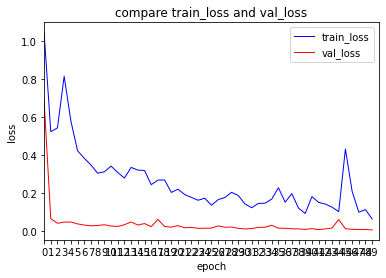

In [60]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,50,1)
x = x.tolist()
# print(type(x),type(train_loss))
plt.title('compare train_loss and val_loss') 
plt.xlabel('epoch') 
plt.ylabel('loss') 
plt.xlim(0,50) 
plt.xticks(np.arange(0,50,1)) 
plt.plot(x, train_loss, color='blue', linewidth=1.0,label = 'train_loss')
plt.plot(x, val_loss, color='red', linewidth=1.0, label="val_loss")
plt.legend()
plt.savefig('loss.png')
plt.show()

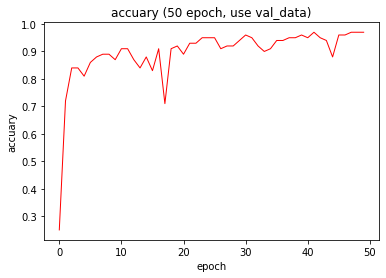

<Figure size 432x288 with 0 Axes>

In [48]:
plt.title('accuary (50 epoch, use val_data)') 
plt.xlabel('epoch') 
plt.ylabel('accuary') 
plt.plot(x, accuary, color='red', linewidth=1.0)
plt.show()
plt.savefig('accuary.png')